In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [3]:
import itertools

In [5]:
def money_score(X_train, y_train, X_val, y_val, var_count: int = None,
                var_penalty: int = 200, model_type='rf', model = None,
                model_size: int = 1, hit_perc: float = 0.2,
                outlabeling: bool=False):
  """
  Tests the variable selection by attempting to fit a model
  """
  if var_count is None:
    var_count = len(X_train[0])

  n = len(y_val)
  hit_count = int(np.floor(n * hit_perc))
  hit_value = 10000 // hit_count
  # I assume that model with no features would select people at random.
  # Since order in y_val is randomized, wlog we assume it selected first
  # x people.
  if var_count == 0:
    true_p = np.sum(y_val[0:hit_count])
    return true_p * hit_value
  if model_type == 'rf':
    model = RandomForestClassifier(n_estimators=30*model_size)
  elif model_type == 'fnn':
    layers = [var_count+2 for i in range(model_size + 1)]
    model = MLPClassifier(hidden_layer_sizes=layers,
                          solver='lbfgs', max_iter=10000)
  elif model_type == 'logreg':
    model = LogisticRegression()
  elif model_type == 'knn':
    model = KNeighborsClassifier(n_neighbors=model_size)
  elif model_type == 'precomp':
    pass
  else:
    model = LogisticRegression()

  model.fit(X_train, y_train)
  if model.classes_[0] == 0:
    zero_index = 0
  else:
    zero_index = 1

  # np.argsort patrzy na sortowanie rosnąco, więc by mieć obserwacje,
  # które są najbardziej prawdopodobne w klasie 1, patrzymy na te,
  # które są najmniej prawdopodobne w klasie 0.
  probas = model.predict_proba(X_val)[:,zero_index]

  if outlabeling:
    isofor = IsolationForest()
    isofor.fit(X_train)
    out_labels = isofor.predict(X_val)
    for i, val in enumerate(out_labels):
      if val == -1:
        probas[i] = 0
  ranking = np.argsort(probas)

  selected = ranking[0:hit_count]
  true_p = np.sum(y_val[selected])

  return true_p * hit_value - var_count * var_penalty

In [6]:
def selection_score_CV(X, y, selection, nfolds=5, seed: int = 42,
                       model_type='rf', model=None,
                       model_size: int = 1, var_penalty: int = 200,
                       outlabeling: bool=False):
  """
  Calculates the money score via cross-validation.

  :param X: dataset
  :param y: answer vector
  :param selection: a boolean array containing information whether each column
    was selected or not
  :param nfolds: number of crossvalidation folds
  :param seed: the seed for the random generator responsible for divinding the
    dataset into folds
  :param model_type: look up model_type in featuresel_bidirectional()
  :param model: the model for testing, applicable only if model_type='precomp'
  :param model_size: as above
  :param var_penalty: the penalty for each variable used, you can use lower than
    default when testing with smaller models
  :param outlabeling: if True, the strategy of the model will be to first
    label all the outliers as positives and only then consider the remaining
    ones.

  :return: a single float with the average score across the folds.
  """
  # Shaving the nonselected variables and randomizing the order for a fair comparison.
  np.random.seed(seed)
  X = X[:, selection]
  n = len(X)
  var_count = np.sum(selection)
  perm = np.random.permutation(n)
  X = X[perm]
  y = y[perm]

  # Assigning observations to the folds
  folds_X = [[] for i in range(nfolds)]
  folds_y = [[] for i in range(nfolds)]
  for i, obsv in enumerate(X):
    to = i % nfolds
    folds_X[to].append(obsv)
    folds_y[to].append(y[i])

  # Turning things into numpy arrays
  for i in range(nfolds):
    folds_X[i] = np.row_stack(folds_X[i])
    folds_y[i] = np.array(folds_y[i])

  # CV
  scores = []
  for i in range(nfolds):
    X_val = folds_X[i]
    y_val = folds_y[i]

    ipp = (i+1) % nfolds
    X_train = folds_X[ipp]
    y_train = folds_y[ipp]
    for j in range(2, nfolds):
      ipj = (i+j) % nfolds
      X_train = np.concatenate((X_train, folds_X[ipj]), axis=0)
      y_train = np.concatenate((y_train, folds_y[ipj]))

    score = money_score(X_train, y_train, X_val, y_val,
                        var_count=var_count, hit_perc=0.2,
                        model_type=model_type, model=model,
                        model_size=model_size, var_penalty=var_penalty,
                        outlabeling=outlabeling)
    scores.append(score)

  scores = np.array(scores)
  return np.mean(scores)

In [7]:
def featuresel_bidirectional(X, y, number_of_tries: int = 5,
                             starting_fraction: float = None,
                             max_iter: int = 1000, model_type='rf', model=None,
                             model_size: int = None, var_penalty: int = 200,
                             progress_bar: bool = True,
                             results_show: bool = True):
  """
  Uses a probability predicting model on an iteratively modified
  set of features to locally determine the subset of "relevant" features.
  Repeats the procedure multiple times from random starting subsets to
  approximate the global optimum.

  Parameters:
  :param X: the observations to fit the model on which.
  :param y: the answer vector for those observations.
  :param number_of_tries: the number of random subsets to start the search from.
  :param starting_fraction: approximate fraction of features to randomly select
    into the starting subset. If None, it will be adjusted so that around 10
    features are initially selected.
  :param max_iter: the maximum number of iterations in each try.
  :param model_type: the type of model to use for predicting probabilities.
    Currently implemented: 'fnn' (watch out, slow as hell), 'logreg' and 'rf',
    'knn' and 'precomp'.
  :param model: the model used for testing, has to have .fit() that works
    regardless of data dimensions and .predict_proba() methods. Applicable only
    if the model_type is 'precomp'.
  :param model_size: the size of the testing model, the higher the bigger.
    If left at None, it will be adjusted to the number of features.
    Relevant only if model_type is 'rf' (will be responsible for the number of
    trees) or 'fnn' (will be responsible for the number of hidden layers).
  :param var_penalty: allows you to adjust the penalty for the number of
    variables. The reason for doing that is that testing models are very basic
    and simple and they will score lower than actual models built on the same
    variables.
  :param progress_bar: toggles the progress bar.
  :param results_show: prints the intermediate results.

  :return: a list of indices of the "relevant" features.
  """
  p = len(X[0])
  if starting_fraction is None:
    if p <= 10:
      starting_fraction = 0.5
    else:
      starting_fraction = 10/p

  assert starting_fraction >= 0.0 and starting_fraction <= 1.0, "starting_fraction parameter must be between 0 and 1."

  if model_size is None:
    model_size = (100 // p) + 1

  best_found = []
  found_score = -1
  for _ in range(number_of_tries):
    # Initializing a constant seed for random generators in that try,
    # to ensure that each CV split, while still random, will be the same
    # throughout the single score maximalization procedure.
    seed = np.random.randint(low=3, high=2147483647)
    # Preparing the starting feature subset.
    selected = [False for i in range(p)]
    for i in range(p):
      rng = np.random.rand()
      if rng < starting_fraction:
        selected[i] = True

    # Getting an accuracy on the starting subset for reference.
    # We want to start from scratch every time, as our goal is to end up in
    # different local optima if possible and then select the best out of them.
    best_score = selection_score_CV(X, y, selected, seed=seed,
                                    model_type=model_type, model=model,
                                    model_size=model_size, var_penalty=var_penalty)

    # Searching for the locally best feature subset.
    for j in range(max_iter):
      # If that remains a -1, it means it's time to stop.
      best_change = -1
      if progress_bar:
        print("Progress bar: ", end='')
      for i in range(p):
        if progress_bar:
          if p < 50:
            print('=', end='')
          elif i % (p//50) == 0:
            print('=', end='')
        selected[i] = not selected[i]
        score = selection_score_CV(X, y, selected, seed=seed,
                                   model_type=model_type, model=model,
                                   model_size=model_size, var_penalty=var_penalty)
        if score > best_score:
          best_score = score
          best_change = i
        selected[i] = not selected[i]

      if progress_bar:
        print("Iteration "+str(j)+" completed!")

      if best_change == -1:
        break
      else:
        selected[best_change] = not selected[best_change]

    if progress_bar:
      print("Bidirectional search completed!\n\n\n")

    found_features = [index for index, value in enumerate(selected) if value]
    if results_show:
      print("Features: ", found_features)
      print("Money score: ", best_score)
    if best_score > found_score:
      found_score = best_score
      best_found = found_features
      if results_show:
        print("New high score!")

    if results_show:
      print("\n\n")

  return best_found

In [8]:
def write_selection(selection, score, filepath, mode):
  """
  Function that writes the selection and its score to a given file

  :param selection: indices of the selected features
  :param score: score calculated for that selection
  :param filepath: path to the file in which the information will be written
  :param mode: 'w' for rewrite, 'a' for append.
  """
  assert mode == 'w' or mode == 'a', "Unknown mode of writing."
  with open(filepath, mode) as writer:
    writer.write("Selected features: \n")
    if len(selection) == 0:
      writer.write("None\n")
    else:
      writer.write("[")
      for i in range(len(selection)-1):
        writer.write(str(selection[i]))
        writer.write(", ")
      writer.write(str(selection[len(selection)-1]))
      writer.write("]")
      writer.write("\n")
    writer.write("Average score: ")
    writer.write(str(score))
    writer.write("\n")

def after_selector_search(X, y, selector_output, output_file1, output_file2,
                          number_of_searches: int = 10,
                          number_of_validations: int = 30,
                          model_type='rf', model_search=None, model_test=None,
                          model_size: int = 4, var_penalty: int = 200,
                          search_buff: float = 1.0, progress_bar: bool = True):
  """
  Performs a randomized bidirectional search for the best subset of a
  set of variables selected in a different way.

  :param X: observations
  :param y: answer vector
  :param selector_output: the set of indices of interesting variables.
    X and selector_output should match so that X[:, selector_output] contains
    the interesting columns.
  :param output_file1: a path to the file in which all of the results of
    individual searches will be saved to (so that you can go back, check for
    close calls if there will be a third stage of model building).
    This file will be appended with each iteration.
  :param output_file2: a path to the file in which the best subset found will
    be saved. This file will be replaced each time.
  :param number_of_searches: how many individual searches to do. By default 10,
    but if you have time, feel free to increase it.
  :param number_of_validations: on how many seeds will each found subset be
    checked.
  :param model_type: the model type that is used for testing. Available choices
    are 'rf' (random forest), 'logreg' (logistic regression), 'ffn' (simple
    neural network) and 'precomp' (predefined by used and passed via the
    'model_search' and 'model_test' variables). By default 'rf'.
    In case of 'precomp', both models have to have .fit() and .predict_proba()
    methods implemented.
  :param model_search: used for 'precomp' value of the 'model_type' argument.
    This is the model that will be used during the search. Beware not to
    put a model that is too big for that, as it can greatly slow down the
    calculation.
  :param model_test: used for 'precomp' value of the 'model_type' argument.
    This is the model that will be used for calculating the score of a found
    result.
  :param model_size: affects the number of classifiers of random forest and the
    number of layers of the ffn.
  :param var_penalty: allows for adjusting the penalty for the number of
    variables (for this function discouraged).
  :param search_buff: the decrease of var_penalty for the testing model (as
    a number to multiply it by). By default, it's 1.0, but I recommend
    performing some experiments with lower values (i.e. 0.8) and see whether
    that improves the final scores.
  :param progress_bar: toggles the progress bar.

  :returns: nothing, all the relevant output will be stored in the files.
  """
  X_ws = X[:, selector_output]
  search_var_penalty = int(var_penalty * search_buff)
  # shouldn't drop below that
  best_score = -10000000
  best_found = selector_output

  for i in range(number_of_searches):
    found = featuresel_bidirectional(X_ws, y, number_of_tries=1,
                                     model_type=model_type, model=model_search,
                                     model_size=model_size,
                                     var_penalty=search_var_penalty,
                                     progress_bar=progress_bar,
                                     results_show=False)
    selected = selector_output[found]
    selected_bool = [False for i in range(len(selector_output))]
    for val in found:
      selected_bool[val] = True

    print("Selection: ", selected)
    if progress_bar:
      print("Starting the subselection evaluation.")
      print("Progress bar: ", end='')

    results = []
    for j in range(number_of_validations):
      if progress_bar:
        print("=", end='')
      seed = np.random.randint(low=3, high=2147483647)
      result_j = selection_score_CV(X_ws, y, selection=selected_bool,
                                    seed=seed, model_type=model_type,
                                    model=model_test, model_size=3*model_size,
                                    var_penalty=var_penalty)
      results.append(result_j)

    if progress_bar:
      print()

    results = np.array(results)
    avg_score = np.mean(results)
    print("Score: ", avg_score)

    if progress_bar:
      print("Evaluation finished, writing results.")

    write_selection(selection=selected, score=avg_score,
                    filepath=output_file1, mode='a')

    if avg_score > best_score:
      best_found = selected
      best_score = avg_score
      write_selection(selection=selected, score=avg_score,
                      filepath=output_file2, mode='w')

    if progress_bar:
      print("Search "+str(i)+" finished! \n\n\n")

  return

In [9]:
def full_search(X, y, confirmed, pending, output_file,
                number_of_validations: int = 100,
                model_type='rf', model=None, model_size: int = 4,
                var_penalty: int = 200):
  """
  Checks all of the subsets of a given selection, builds models on each one
  and does a serious validation.
  """
  selection = np.concatenate((confirmed, pending), axis=None)
  X_ws = X[:, selection]

  subsets = list(itertools.product([False, True], repeat=len(pending)))
  subsets = [np.array(arr) for arr in subsets]
  conf_bool = np.array([True for val in confirmed])
  subsets = [np.concatenate((conf_bool, arr), axis=None) for arr in subsets]

  for subset in subsets:
    results = []
    for j in range(number_of_validations):
      seed = np.random.randint(low=3, high=2147483647)
      result_j = selection_score_CV(X_ws, y, selection=subset,
                                    seed=seed, model_type=model_type,
                                    model=model, model_size=3*model_size,
                                    var_penalty=var_penalty)
      results.append(result_j)

    results = np.array(results)
    avg_score = np.mean(results)
    subset_indices = selection[subset]
    print("subset: ", subset_indices, "done!")
    print("avg score: ", avg_score)

    write_selection(selection=subset_indices, score=avg_score,
                    filepath=output_file, mode='a')

  return

In [10]:
def load_data(path_X, path_y, standardize: bool=True, filter_outs: bool=False,
              seed=42):
  X = pd.read_csv(path_X, sep=' ', header=None)
  X = X.values

  y = pd.read_csv(path_y, header=None)
  y = y.values
  y = y.reshape(-1)

  if filter_outs:
    isofor = IsolationForest(random_state=seed)
    out_labels = isofor.fit_predict(X)
    inliner_indices = [i for i, val in enumerate(out_labels) if val == 1]
    X = X[inliner_indices]
    y = y[inliner_indices]

  if standardize:
    X_columns = []
    for i in range(len(X[0])):
      X_columns.append(X[:,i])

    for i, column in enumerate(X_columns):
      loc = np.mean(column)
      scale = np.std(column)
      X_columns[i] = (column - loc)/scale

    X = np.column_stack(X_columns)

  return X, y

# BORUTA

In [10]:
# The package code crashed with the Google Colab's version of numpy, so I stole it for repairs.
"""
Author: Daniel Homola <dani.homola@gmail.com>

Original code and method by: Miron B Kursa, https://m2.icm.edu.pl/boruta/

License: BSD 3 clause
"""

from __future__ import print_function, division
import numpy as np
import scipy as sp
from sklearn.utils import check_random_state, check_X_y
from sklearn.base import TransformerMixin, BaseEstimator


class BorutaPy(BaseEstimator, TransformerMixin):
    """
    Improved Python implementation of the Boruta R package.

    The improvements of this implementation include:
    - Faster run times:
        Thanks to scikit-learn's fast implementation of the ensemble methods.
    - Scikit-learn like interface:
        Use BorutaPy just like any other scikit learner: fit, fit_transform and
        transform are all implemented in a similar fashion.
    - Modularity:
        Any ensemble method could be used: random forest, extra trees
        classifier, even gradient boosted trees.
    - Two step correction:
        The original Boruta code corrects for multiple testing in an overly
        conservative way. In this implementation, the Benjamini Hochberg FDR is
        used to correct in each iteration across active features. This means
        only those features are included in the correction which are still in
        the selection process. Following this, each that passed goes through a
        regular Bonferroni correction to check for the repeated testing over
        the iterations.
    - Percentile:
        Instead of using the max values of the shadow features the user can
        specify which percentile to use. This gives a finer control over this
        crucial parameter. For more info, please read about the perc parameter.
    - Automatic tree number:
        Setting the n_estimator to 'auto' will calculate the number of trees
        in each itartion based on the number of features under investigation.
        This way more trees are used when the training data has many feautres
        and less when most of the features have been rejected.
    - Ranking of features:
        After fitting BorutaPy it provides the user with ranking of features.
        Confirmed ones are 1, Tentatives are 2, and the rejected are ranked
        starting from 3, based on their feautre importance history through
        the iterations.

    We highly recommend using pruned trees with a depth between 3-7.

    For more, see the docs of these functions, and the examples below.

    Original code and method by: Miron B Kursa, https://m2.icm.edu.pl/boruta/

    Boruta is an all relevant feature selection method, while most other are
    minimal optimal; this means it tries to find all features carrying
    information usable for prediction, rather than finding a possibly compact
    subset of features on which some classifier has a minimal error.

    Why bother with all relevant feature selection?
    When you try to understand the phenomenon that made your data, you should
    care about all factors that contribute to it, not just the bluntest signs
    of it in context of your methodology (yes, minimal optimal set of features
    by definition depends on your classifier choice).

    Parameters
    ----------

    estimator : object
        A supervised learning estimator, with a 'fit' method that returns the
        feature_importances_ attribute. Important features must correspond to
        high absolute values in the feature_importances_.

    n_estimators : int or string, default = 1000
        If int sets the number of estimators in the chosen ensemble method.
        If 'auto' this is determined automatically based on the size of the
        dataset. The other parameters of the used estimators need to be set
        with initialisation.

    perc : int, default = 100
        Instead of the max we use the percentile defined by the user, to pick
        our threshold for comparison between shadow and real features. The max
        tend to be too stringent. This provides a finer control over this. The
        lower perc is the more false positives will be picked as relevant but
        also the less relevant features will be left out. The usual trade-off.
        The default is essentially the vanilla Boruta corresponding to the max.

    alpha : float, default = 0.05
        Level at which the corrected p-values will get rejected in both
        correction steps.

    two_step : Boolean, default = True
        If you want to use the original implementation of Boruta with Bonferroni
        correction only set this to False.

    max_iter : int, default = 100
        The number of maximum iterations to perform.

    random_state : int, RandomState instance or None; default=None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    verbose : int, default=0
        Controls verbosity of output:
        - 0: no output
        - 1: displays iteration number
        - 2: which features have been selected already

    Attributes
    ----------

    n_features_ : int
        The number of selected features.

    support_ : array of shape [n_features]

        The mask of selected features - only confirmed ones are True.

    support_weak_ : array of shape [n_features]

        The mask of selected tentative features, which haven't gained enough
        support during the max_iter number of iterations..

    ranking_ : array of shape [n_features]

        The feature ranking, such that ``ranking_[i]`` corresponds to the
        ranking position of the i-th feature. Selected (i.e., estimated
        best) features are assigned rank 1 and tentative features are assigned
        rank 2.

    Examples
    --------

    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from boruta import BorutaPy

    # load X and y
    # NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
    X = pd.read_csv('examples/test_X.csv', index_col=0).values
    y = pd.read_csv('examples/test_y.csv', header=None, index_col=0).values
    y = y.ravel()

    # define random forest classifier, with utilising all cores and
    # sampling in proportion to y labels
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    # define Boruta feature selection method
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

    # find all relevant features - 5 features should be selected
    feat_selector.fit(X, y)

    # check selected features - first 5 features are selected
    feat_selector.support_

    # check ranking of features
    feat_selector.ranking_

    # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X)

    References
    ----------

    [1] Kursa M., Rudnicki W., "Feature Selection with the Boruta Package"
        Journal of Statistical Software, Vol. 36, Issue 11, Sep 2010
    """

    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.perc = perc
        self.alpha = alpha
        self.two_step = two_step
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y):
        """
        Fits the Boruta feature selection with the provided estimator.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values.
        """

        return self._fit(X, y)

    def transform(self, X, weak=False):
        """
        Reduces the input X to the features selected by Boruta.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.

        weak: boolean, default = False
            If set to true, the tentative features are also used to reduce X.

        Returns
        -------
        X : array-like, shape = [n_samples, n_features_]
            The input matrix X's columns are reduced to the features which were
            selected by Boruta.
        """

        return self._transform(X, weak)

    def fit_transform(self, X, y, weak=False):
        """
        Fits Boruta, then reduces the input X to the selected features.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values.

        weak: boolean, default = False
            If set to true, the tentative features are also used to reduce X.

        Returns
        -------
        X : array-like, shape = [n_samples, n_features_]
            The input matrix X's columns are reduced to the features which were
            selected by Boruta.
        """

        self._fit(X, y)
        return self._transform(X, weak)

    def _fit(self, X, y):
        # check input params
        self._check_params(X, y)
        self.random_state = check_random_state(self.random_state)
        # setup variables for Boruta
        n_sample, n_feat = X.shape
        _iter = 1
        # holds the decision about each feature:
        # 0  - default state = tentative in original code
        # 1  - accepted in original code
        # -1 - rejected in original code
        dec_reg = np.zeros(n_feat, dtype=int)                                     # I changed np.int to int, according to the new numpy rules
        # counts how many times a given feature was more important than
        # the best of the shadow features
        hit_reg = np.zeros(n_feat, dtype=int)                                     # I changed np.int to int, according to the new numpy rules
        # these record the history of the iterations
        imp_history = np.zeros(n_feat, dtype=float)                               # I changed np.float to float, according to the new numpy rules
        sha_max_history = []

        # set n_estimators
        if self.n_estimators != 'auto':
            self.estimator.set_params(n_estimators=self.n_estimators)

        # main feature selection loop
        while np.any(dec_reg == 0) and _iter < self.max_iter:
            # find optimal number of trees and depth
            if self.n_estimators == 'auto':
                # number of features that aren't rejected
                not_rejected = np.where(dec_reg >= 0)[0].shape[0]
                n_tree = self._get_tree_num(not_rejected)
                self.estimator.set_params(n_estimators=n_tree)

            # make sure we start with a new tree in each iteration
            self.estimator.set_params(random_state=self.random_state)

            # add shadow attributes, shuffle them and train estimator, get imps
            cur_imp = self._add_shadows_get_imps(X, y, dec_reg)

            # get the threshold of shadow importances we will use for rejection
            imp_sha_max = np.percentile(cur_imp[1], self.perc)

            # record importance history
            sha_max_history.append(imp_sha_max)
            imp_history = np.vstack((imp_history, cur_imp[0]))

            # register which feature is more imp than the max of shadows
            hit_reg = self._assign_hits(hit_reg, cur_imp, imp_sha_max)

            # based on hit_reg we check if a feature is doing better than
            # expected by chance
            dec_reg = self._do_tests(dec_reg, hit_reg, _iter)

            # print out confirmed features
            if self.verbose > 0 and _iter < self.max_iter:
                self._print_results(dec_reg, _iter, 0)
            if _iter < self.max_iter:
                _iter += 1

        # we automatically apply R package's rough fix for tentative ones
        confirmed = np.where(dec_reg == 1)[0]
        tentative = np.where(dec_reg == 0)[0]
        # ignore the first row of zeros
        tentative_median = np.median(imp_history[1:, tentative], axis=0)
        # which tentative to keep
        tentative_confirmed = np.where(tentative_median
                                       > np.median(sha_max_history))[0]
        tentative = tentative[tentative_confirmed]

        # basic result variables
        self.n_features_ = confirmed.shape[0]
        self.support_ = np.zeros(n_feat, dtype=bool)                              # I changed np.bool to bool, according to the new numpy rules
        self.support_[confirmed] = 1
        self.support_weak_ = np.zeros(n_feat, dtype=bool)                         # I changed np.bool to bool, according to the new numpy rules
        self.support_weak_[tentative] = 1

        # ranking, confirmed variables are rank 1
        self.ranking_ = np.ones(n_feat, dtype=int)                                # I changed np.int to int, according to the new numpy rules
        # tentative variables are rank 2
        self.ranking_[tentative] = 2
        # selected = confirmed and tentative
        selected = np.hstack((confirmed, tentative))
        # all rejected features are sorted by importance history
        not_selected = np.setdiff1d(np.arange(n_feat), selected)
        # large importance values should rank higher = lower ranks -> *(-1)
        imp_history_rejected = imp_history[1:, not_selected] * -1

        # update rank for not_selected features
        if not_selected.shape[0] > 0:
                # calculate ranks in each iteration, then median of ranks across feats
                iter_ranks = self._nanrankdata(imp_history_rejected, axis=1)
                rank_medians = np.nanmedian(iter_ranks, axis=0)
                ranks = self._nanrankdata(rank_medians, axis=0)

                # set smallest rank to 3 if there are tentative feats
                if tentative.shape[0] > 0:
                    ranks = ranks - np.min(ranks) + 3
                else:
                    # and 2 otherwise
                    ranks = ranks - np.min(ranks) + 2
                self.ranking_[not_selected] = ranks
        else:
            # all are selected, thus we set feature supports to True
            self.support_ = np.ones(n_feat, dtype=bool)                           # I changed np.bool to bool, according to the new numpy rules

        # notify user
        if self.verbose > 0:
            self._print_results(dec_reg, _iter, 1)
        return self

    def _transform(self, X, weak=False):
        # sanity check
        try:
            self.ranking_
        except AttributeError:
            raise ValueError('You need to call the fit(X, y) method first.')

        if weak:
            X = X[:, self.support_ + self.support_weak_]
        else:
            X = X[:, self.support_]
        return X

    def _get_tree_num(self, n_feat):
        depth = self.estimator.get_params()['max_depth']
        if depth == None:
            depth = 10
        # how many times a feature should be considered on average
        f_repr = 100
        # n_feat * 2 because the training matrix is extended with n shadow features
        multi = ((n_feat * 2) / (np.sqrt(n_feat * 2) * depth))
        n_estimators = int(multi * f_repr)
        return n_estimators

    def _get_imp(self, X, y):
        try:
            self.estimator.fit(X, y)
        except Exception as e:
            raise ValueError('Please check your X and y variable. The provided'
                             'estimator cannot be fitted to your data.\n' + str(e))
        try:
            imp = self.estimator.feature_importances_
        except Exception:
            raise ValueError('Only methods with feature_importance_ attribute '
                             'are currently supported in BorutaPy.')
        return imp

    def _get_shuffle(self, seq):
        self.random_state.shuffle(seq)
        return seq

    def _add_shadows_get_imps(self, X, y, dec_reg):
        # find features that are tentative still
        x_cur_ind = np.where(dec_reg >= 0)[0]
        x_cur = np.copy(X[:, x_cur_ind])
        x_cur_w = x_cur.shape[1]
        # deep copy the matrix for the shadow matrix
        x_sha = np.copy(x_cur)
        # make sure there's at least 5 columns in the shadow matrix for
        while (x_sha.shape[1] < 5):
            x_sha = np.hstack((x_sha, x_sha))
        # shuffle xSha
        x_sha = np.apply_along_axis(self._get_shuffle, 0, x_sha)
        # get importance of the merged matrix
        imp = self._get_imp(np.hstack((x_cur, x_sha)), y)
        # separate importances of real and shadow features
        imp_sha = imp[x_cur_w:]
        imp_real = np.zeros(X.shape[1])
        imp_real[:] = np.nan
        imp_real[x_cur_ind] = imp[:x_cur_w]
        return imp_real, imp_sha

    def _assign_hits(self, hit_reg, cur_imp, imp_sha_max):
        # register hits for features that did better than the best of shadows
        cur_imp_no_nan = cur_imp[0]
        cur_imp_no_nan[np.isnan(cur_imp_no_nan)] = 0
        hits = np.where(cur_imp_no_nan > imp_sha_max)[0]
        hit_reg[hits] += 1
        return hit_reg

    def _do_tests(self, dec_reg, hit_reg, _iter):
        active_features = np.where(dec_reg >= 0)[0]
        hits = hit_reg[active_features]
        # get uncorrected p values based on hit_reg
        to_accept_ps = sp.stats.binom.sf(hits - 1, _iter, .5).flatten()
        to_reject_ps = sp.stats.binom.cdf(hits, _iter, .5).flatten()

        if self.two_step:
            # two step multicor process
            # first we correct for testing several features in each round using FDR
            to_accept = self._fdrcorrection(to_accept_ps, alpha=self.alpha)[0]
            to_reject = self._fdrcorrection(to_reject_ps, alpha=self.alpha)[0]

            # second we correct for testing the same feature over and over again
            # using bonferroni
            to_accept2 = to_accept_ps <= self.alpha / float(_iter)
            to_reject2 = to_reject_ps <= self.alpha / float(_iter)

            # combine the two multi corrections, and get indexes
            to_accept *= to_accept2
            to_reject *= to_reject2
        else:
            # as in th original Boruta, we simply do bonferroni correction
            # with the total n_feat in each iteration
            to_accept = to_accept_ps <= self.alpha / float(len(dec_reg))
            to_reject = to_reject_ps <= self.alpha / float(len(dec_reg))

        # find features which are 0 and have been rejected or accepted
        to_accept = np.where((dec_reg[active_features] == 0) * to_accept)[0]
        to_reject = np.where((dec_reg[active_features] == 0) * to_reject)[0]

        # updating dec_reg
        dec_reg[active_features[to_accept]] = 1
        dec_reg[active_features[to_reject]] = -1
        return dec_reg

    def _fdrcorrection(self, pvals, alpha=0.05):
        """
        Benjamini/Hochberg p-value correction for false discovery rate, from
        statsmodels package. Included here for decoupling dependency on statsmodels.

        Parameters
        ----------
        pvals : array_like
            set of p-values of the individual tests.
        alpha : float
            error rate

        Returns
        -------
        rejected : array, bool
            True if a hypothesis is rejected, False if not
        pvalue-corrected : array
            pvalues adjusted for multiple hypothesis testing to limit FDR
        """
        pvals = np.asarray(pvals)
        pvals_sortind = np.argsort(pvals)
        pvals_sorted = np.take(pvals, pvals_sortind)
        nobs = len(pvals_sorted)
        ecdffactor = np.arange(1, nobs + 1) / float(nobs)

        reject = pvals_sorted <= ecdffactor * alpha
        if reject.any():
            rejectmax = max(np.nonzero(reject)[0])
            reject[:rejectmax] = True

        pvals_corrected_raw = pvals_sorted / ecdffactor
        pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
        pvals_corrected[pvals_corrected > 1] = 1
        # reorder p-values and rejection mask to original order of pvals
        pvals_corrected_ = np.empty_like(pvals_corrected)
        pvals_corrected_[pvals_sortind] = pvals_corrected
        reject_ = np.empty_like(reject)
        reject_[pvals_sortind] = reject
        return reject_, pvals_corrected_

    def _nanrankdata(self, X, axis=1):
        """
        Replaces bottleneck's nanrankdata with scipy and numpy alternative.
        """
        ranks = sp.stats.mstats.rankdata(X, axis=axis)
        ranks[np.isnan(X)] = np.nan
        return ranks

    def _check_params(self, X, y):
        """
        Check hyperparameters as well as X and y before proceeding with fit.
        """
        # check X and y are consistent len, X is Array and y is column
        X, y = check_X_y(X, y)
        if self.perc <= 0 or self.perc > 100:
            raise ValueError('The percentile should be between 0 and 100.')

        if self.alpha <= 0 or self.alpha > 1:
            raise ValueError('Alpha should be between 0 and 1.')

    def _print_results(self, dec_reg, _iter, flag):
        n_iter = str(_iter) + ' / ' + str(self.max_iter)
        n_confirmed = np.where(dec_reg == 1)[0].shape[0]
        n_rejected = np.where(dec_reg == -1)[0].shape[0]
        cols = ['Iteration: ', 'Confirmed: ', 'Tentative: ', 'Rejected: ']

        # still in feature selection
        if flag == 0:
            n_tentative = np.where(dec_reg == 0)[0].shape[0]
            content = map(str, [n_iter, n_confirmed, n_tentative, n_rejected])
            if self.verbose == 1:
                output = cols[0] + n_iter
            elif self.verbose > 1:
                output = '\n'.join([x[0] + '\t' + x[1] for x in zip(cols, content)])

        # Boruta finished running and tentatives have been filtered
        else:
            n_tentative = np.sum(self.support_weak_)
            content = map(str, [n_iter, n_confirmed, n_tentative, n_rejected])
            result = '\n'.join([x[0] + '\t' + x[1] for x in zip(cols, content)])
            output = "\n\nBorutaPy finished running.\n\n" + result
        print(output)


# TESTS:

In [11]:
X, y = load_data("x_train.txt", "y_train.txt")

In [ ]:
print(y)
print(X[0:5])
print(y.shape, X.shape)

[0 0 1 ... 0 0 0]
[[-1.34108452 -1.19060826 -0.59564832 ...  1.42942589 -0.62042441
  -0.41718029]
 [-0.72102972 -0.80573135 -1.43982214 ...  0.51277217  0.53388095
  -1.10634616]
 [-1.40561259 -0.62198189 -0.80992346 ...  0.45665618  0.39051437
  -0.90059694]
 [ 0.32659967  0.22333625 -0.05111822 ...  0.18851043 -0.94586428
   0.09902513]
 [-0.02853159 -0.23919905 -0.27735076 ...  0.73075823  0.1701234
  -0.02523711]]
(5000,) (5000, 500)


In [ ]:
print(np.sum(y==1))

2496


### Outliers seem to mostly belong to the positive class...

In [ ]:
fractions_of_pos_outliers = []
for i in range(42, 142):
  X, y = load_data("x_train.txt", "y_train.txt", filter_outs=True, seed=i)
  filtered = 5000 - X.shape[0]
  filt_pos = 2496 - np.sum(y)
  fractions_of_pos_outliers.append(filt_pos / filtered)

print(fractions_of_pos_outliers)

[0.6, 0.6666666666666666, 0.4722222222222222, 0.2857142857142857, 0.64, 0.625, 0.582089552238806, 0.7, 0.4444444444444444, 0.7142857142857143, 0.7631578947368421, 0.4782608695652174, 0.4523809523809524, 0.6551724137931034, 0.5833333333333334, 0.6, 0.543859649122807, 0.46153846153846156, 0.47058823529411764, 0.6086956521739131, 0.45714285714285713, 0.6363636363636364, 0.5714285714285714, 0.5806451612903226, 0.5294117647058824, 0.5416666666666666, 0.48, 0.6428571428571429, 1.0, 0.5909090909090909, 0.625, 0.5925925925925926, 0.6, 0.5128205128205128, 0.5833333333333334, 0.5, 0.625, 0.55, 0.38461538461538464, 0.5, 0.6, 0.64, 0.7777777777777778, 0.5714285714285714, 0.55, 0.6, 0.6666666666666666, 0.5, 0.75, 0.2857142857142857, 1.0, 0.6666666666666666, 0.3125, 0.5306122448979592, 0.6125, 0.6206896551724138, 0.4, 0.34375, 0.5294117647058824, 0.5714285714285714, 0.5454545454545454, 0.5, 0.45454545454545453, 0.6774193548387096, 0.631578947368421, 0.5769230769230769, 0.42857142857142855, 0.6666666

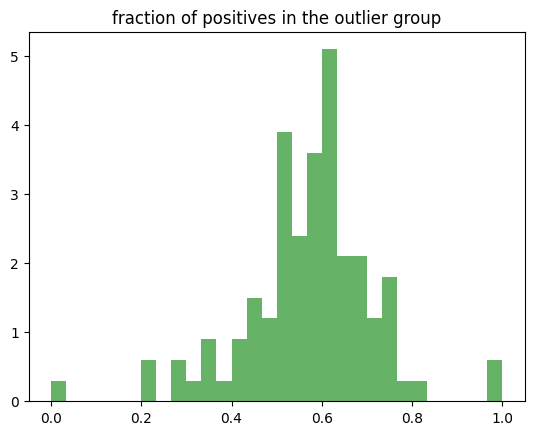

In [ ]:
plt.hist(fractions_of_pos_outliers, bins=30, density=True, alpha=0.6, color='g')
plt.title("fraction of positives in the outlier group")
plt.show()

let's look at it on an example of "important features" only, maybe with lower noise, the correlation will be even stronger?

In [ ]:
boruta_base_not_rejected = [0, 2, 3, 4, 8, 9, 100, 101, 102, 103, 104, 105]
X_not_rejected = X[:, boruta_base_not_rejected]

In [ ]:
fractions_of_pos_outliers = []
for i in range(42, 142):
  isofor = IsolationForest(random_state=i)
  out_labels = isofor.fit_predict(X_not_rejected)

  inliner_indices = [i for i, val in enumerate(out_labels) if val == 1]
  y_nr = y[inliner_indices]

  filtered = 5000 - len(y_nr)
  filt_pos = 2496 - np.sum(y_nr)
  print(filtered, filt_pos)
  fractions_of_pos_outliers.append(filt_pos / filtered)

510 373
519 382
531 389
519 384
513 381
504 369
654 480
552 397
520 383
523 386
555 406
625 455
637 465
616 450
533 392
524 382
691 507
568 420
579 425
465 349
580 421
586 429
474 352
616 455
611 445
493 367
594 430
509 376
506 374
557 409
565 412
529 387
542 406
637 467
573 422
558 413
564 417
556 412
486 361
518 381
433 322
628 454
449 324
548 400
587 428
565 414
581 429
515 377
514 379
531 398
476 343
544 403
572 419
636 466
618 452
568 424
560 413
641 463
500 368
529 393
525 383
558 412
519 385
545 404
613 443
578 426
611 448
616 444
591 429
483 355
485 358
570 425
607 447
550 405
600 434
539 401
558 412
567 415
560 413
552 398
526 379
583 425
576 425
542 400
634 464
628 462
576 421
547 402
576 423
595 436
487 362
570 418
610 443
511 367
553 408
505 374
536 402
537 395
599 436
531 394


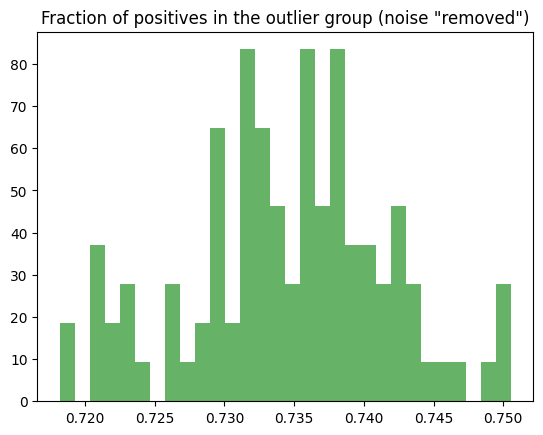

In [ ]:
plt.hist(fractions_of_pos_outliers, bins=30, density=True, alpha=0.6, color='g')
plt.title('Fraction of positives in the outlier group (noise "removed")')
plt.show()

for reference, random forest predictor's accuracy:

In [ ]:
accs = []
tprs = []
rf = RandomForestClassifier(n_estimators=600)
for i in range(42, 142):
  X_train, X_test, y_train, y_test = train_test_split(X_not_rejected, y,
                                                      test_size=0.2,
                                                      random_state=i)
  rf.fit(X_train, y_train)
  preds = rf.predict(X_test)

  hits = np.sum(preds == y_test)
  count = len(y_test)
  tps = np.sum((preds == 1) & (y_test == 1))
  ps = np.sum(preds == 1)

  accs.append(hits / count)
  tprs.append(tps / ps)

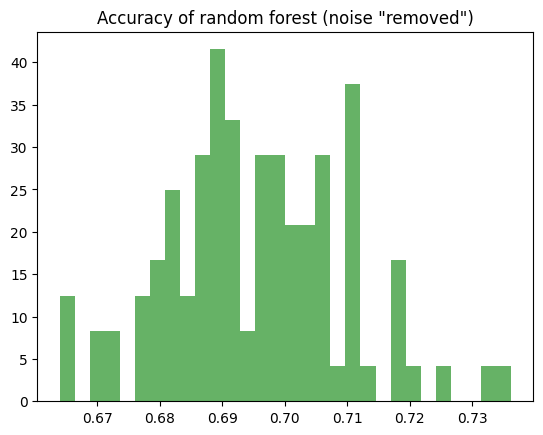

In [ ]:
plt.hist(accs, bins=30, density=True, alpha=0.6, color='g')
plt.title('Accuracy of random forest (noise "removed")')
plt.show()

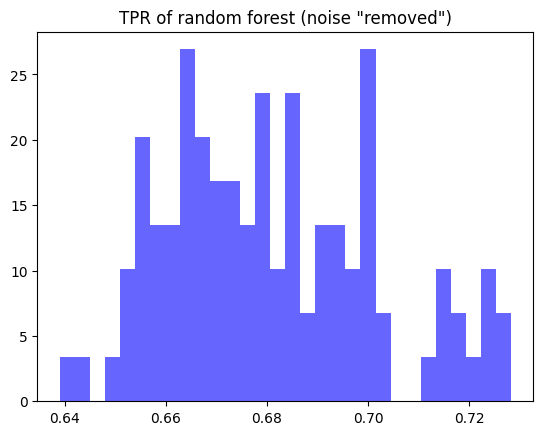

In [ ]:
plt.hist(tprs, bins=30, density=True, alpha=0.6, color='b')
plt.title('TPR of random forest (noise "removed")')
plt.show()

And what if we remove the outliers first, train the model on the subset of remaining observations (and classify outliers as positives)?

In [ ]:
isofor = IsolationForest(random_state=42)
outlabels = isofor.fit_predict(X_not_rejected)

X_inline = X_not_rejected[outlabels==1]
y_inline = y[outlabels==1]
pos_outs = np.sum((y==1) & (outlabels==-1))
neg_outs = np.sum((y==0) & (outlabels==-1))

In [ ]:
accs = []
tprs = []
rf = RandomForestClassifier(n_estimators=600)
for i in range(42, 142):
  X_train, X_test, y_train, y_test = train_test_split(X_inline, y_inline,
                                                      test_size=0.2,
                                                      random_state=i)
  rf.fit(X_train, y_train)
  preds = rf.predict(X_test)

  hits = np.sum(preds == y_test) + pos_outs
  count = len(y_test) + pos_outs + neg_outs
  tps = np.sum((preds == 1) & (y_test == 1)) + pos_outs
  ps = np.sum(preds == 1) + pos_outs + neg_outs

  accs.append(hits / count)
  tprs.append(tps / ps)

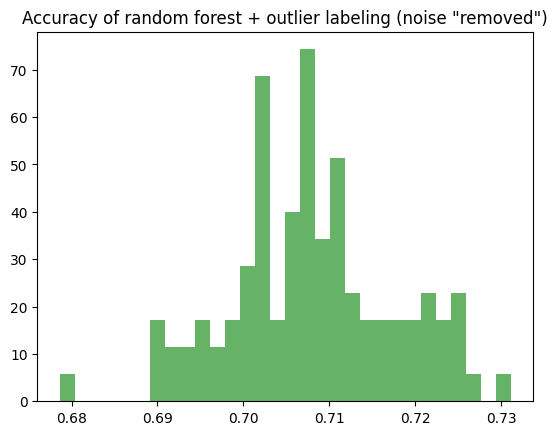

In [ ]:
plt.hist(accs, bins=30, density=True, alpha=0.6, color='g')
plt.title('Accuracy of random forest + outlier labeling (noise "removed")')
plt.show()

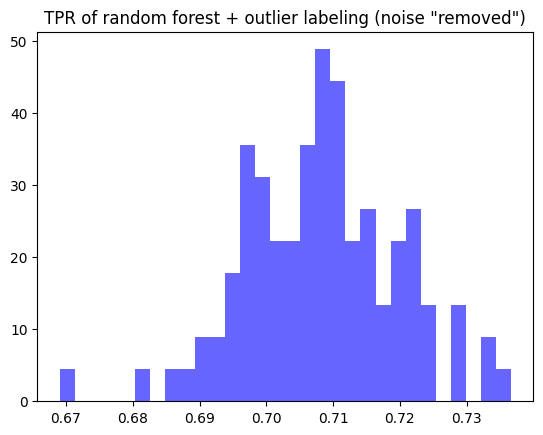

In [ ]:
plt.hist(tprs, bins=30, density=True, alpha=0.6, color='b')
plt.title('TPR of random forest + outlier labeling (noise "removed")')
plt.show()

In [ ]:
accs = []
tprs = []
rf = RandomForestClassifier(n_estimators=600)
for i in range(42, 142):
  X_train, X_test, y_train, y_test = train_test_split(X_inline, y_inline,
                                                      test_size=0.2,
                                                      random_state=i)
  rf.fit(X_train, y_train)
  preds = rf.predict(X_test)

  hits = np.sum(preds == y_test)
  count = len(y_test)
  tps = np.sum((preds == 1) & (y_test == 1))
  ps = np.sum(preds == 1)

  accs.append(hits / count)
  tprs.append(tps / ps)

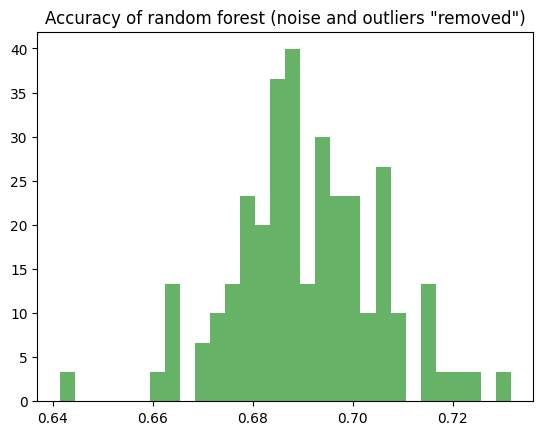

In [ ]:
plt.hist(accs, bins=30, density=True, alpha=0.6, color='g')
plt.title('Accuracy of random forest (noise and outliers "removed")')
plt.show()

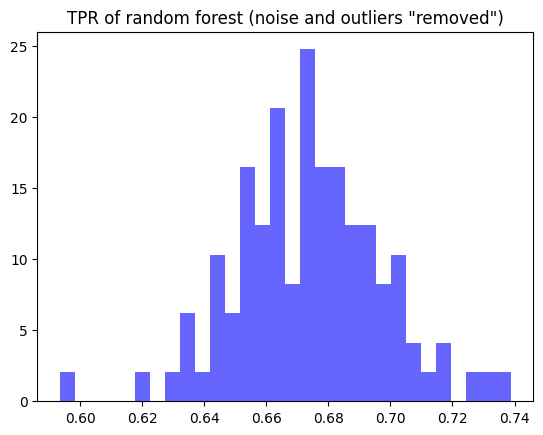

In [ ]:
plt.hist(tprs, bins=30, density=True, alpha=0.6, color='b')
plt.title('TPR of random forest (noise and outliers "removed")')
plt.show()

# Random stuff

In [15]:
X, y = load_data("x_train.txt", "y_train.txt")

In [ ]:
rf = RandomForestClassifier()
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(X,y)
print("feature ranking:")
print(boruta_selector.ranking_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	474
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	15
Rejected: 	474
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	15
Rejected: 	474
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	15
Rejected: 	474
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	15
Rejected: 	474
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	14
Rejected: 	475
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	14
Rejected: 	475
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	14
Rejected: 	475
Iteration: 	16 / 100
Confirmed: 	1

In [ ]:
print(np.argsort(boruta_selector.ranking_))

[100 102   2   3   4 103 104 105   8   9 101   0   5   6 403 285   1 498
   7  64 109 458 155 158 335 351 220 270 215 281 328  39 321 323 129 252
  29 303 412 246  78 266 395 148 311  75  84 291  57 211  35  60 139  74
 464 420 190 133 316 337 360 241 357 273  63 191 322 253 288 495 371 339
 460 479 112 340 184 214 391 319  73 108 203 117  47  38 157 466 226 204
 445 471 195 421 388 313  80 122 161 249 208  27  36 265  86 417 120  21
 359  70 447 296 176  30  34 178 175 227 317  87 334 444 366 463 491 390
 306 484 302 260 106 415 131 146 332 436 284 329 283 373 262 486 264 182
 380  66 422 207 324 304 119 489 290  53 439 156 305 394 481 325 462  90
 199 467 492 426 135 427  76 287 107 318 180 228 198 432 363 189 399 336
 387 355 295 144 490 367 425 397  79 448 441  13 276 163  98 143 145  45
  25 181 298 142  51 113 372 268 348 331 300 210 277 121 187 342 200 247
 309 377  20 365 308 409 138 347 259  46 472 188  88 282 177 221 127 233
  82 213 440 279  32 219 312  83  52 234 476 349  2

In [ ]:
top26 = np.argwhere(boruta_selector.ranking_ < 17).flatten()
print(top26, len(top26))

NameError: name 'boruta_selector' is not defined

In [ ]:
top12 = np.argwhere(boruta_selector.ranking_ < 3).flatten()
print(top12, len(top12))

[  0   2   3   4   8   9 100 101 102 103 104 105] 12


In [ ]:
top26 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 64, 100, 101, 102, 103, 104, 105, 109, 155, 158, 285, 335, 351, 403, 458, 498])
top12 = np.array([0, 2, 3, 4, 8, 9, 100, 101, 102, 103, 104, 105] )

What BORUTA deemed interesting (meaning didn't reject in the first meaningful iteration) without outliers removed:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 64, 100, 101, 102, 103, 104, 105, 109, 155, 158, 285, 335, 351, 403, 458, 498]

 out of those, [2, 3, 4, 8, 9, 100, 101, 102, 103, 104, 105] were deemed to be definitelly iportant and [0] was "tentative".

In [ ]:
X26 = X[:,top26]

In [ ]:
giga_fnn = MLPClassifier(hidden_layer_sizes=[30,30,20,20,10,10,5,5],
                          solver='lbfgs', max_iter=10000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X26, y, test_size=0.2)

In [ ]:
giga_fnn.fit(X_train, y_train)
preds = giga_fnn.predict(X_test)
print(np.sum(preds == y_test))

495


In [ ]:
giga_rf = RandomForestClassifier(n_estimators=1000)
giga_rf.fit(X_train, y_train)
preds = giga_rf.predict(X_test)
print(np.sum(preds == y_test))

673


testing with rf it is...

In [ ]:
after_selector_search(X, y, selector_output=top26,
                      output_file1="top26_boruta_tries.txt",
                      output_file2="top26_boruta_best.txt",
                      model_size=4)

Progress bar: ==========================Iteration 0 completed!
Progress bar: ==========================Iteration 1 completed!
Progress bar: ==========================Iteration 2 completed!
Progress bar: ==========================Iteration 3 completed!
Progress bar: ==========================Iteration 4 completed!
Progress bar: ==========================Iteration 5 completed!
Progress bar: ==========================Iteration 6 completed!
Progress bar: ==========================Iteration 7 completed!
Bidirectional search completed!



Selection:  [  0 102 103 105]
Starting the subselection evaluation.
Progress bar: ==============================
Score:  6365.0
Evaluation finished, writing results.
Search 0 finished! 



Progress bar: ==========================Iteration 0 completed!
Progress bar: ==========================Iteration 1 completed!
Progress bar: ==========================Iteration 2 completed!
Progress bar: ==========================Iteration 3 completed!
Progress bar: ======

In [ ]:
from google.colab import files
files.download("top26_boruta_best.txt")
files.download("top26_boruta_tries.txt")

# Model building

selected variables: 102, 103 and 105

In [12]:
confirmed = np.array([102, 103, 105])
X3 = X[:,confirmed]

First, let's try regular random forest

In [13]:
scores_rf_30 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=1)
  #print(i, score)
  scores_rf_30.append(score)

In [14]:
scores_rf_60 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=2)
  #print(i, score)
  scores_rf_60.append(score)

In [15]:
scores_rf_120 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=4)
  #print(i, score)
  scores_rf_120.append(score)

In [16]:
scores_rf_240 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=8)
  #print(i, score)
  scores_rf_240.append(score)

In [17]:
scores_rf_360 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=12)
  #print(i, score)
  scores_rf_360.append(score)

In [18]:
scores_rf_600 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=20)
  #print(i, score)
  scores_rf_600.append(score)

In [19]:
scores_rf_900 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='rf', model_size=30)
  #print(i, score)
  scores_rf_900.append(score)

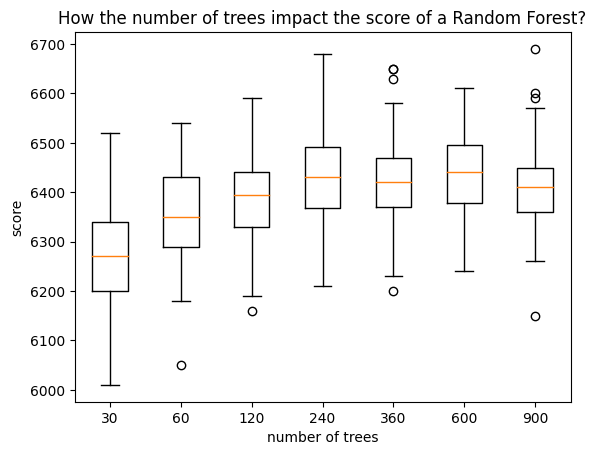

In [20]:
plt.boxplot((scores_rf_30, scores_rf_60, scores_rf_120, scores_rf_240,
             scores_rf_360, scores_rf_600, scores_rf_900),
            labels=[30, 60, 120, 240, 360, 600, 900])
plt.title("How the number of trees impact the score of a Random Forest?")
plt.ylabel("score")
plt.xlabel("number of trees")
plt.show()

Then a KNN

In [22]:
scores_knn_10 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=10)
  #print(i, score)
  scores_knn_10.append(score)

In [23]:
scores_knn_20 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=20)
  #print(i, score)
  scores_knn_20.append(score)

In [24]:
scores_knn_50 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=50)
  #print(i, score)
  scores_knn_50.append(score)

In [25]:
scores_knn_100 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=100)
  #print(i, score)
  scores_knn_100.append(score)

In [26]:
scores_knn_200 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=200)
  #print(i, score)
  scores_knn_200.append(score)

In [27]:
scores_knn_300 = []
for i in range(100):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=300)
  #print(i, score)
  scores_knn_300.append(score)

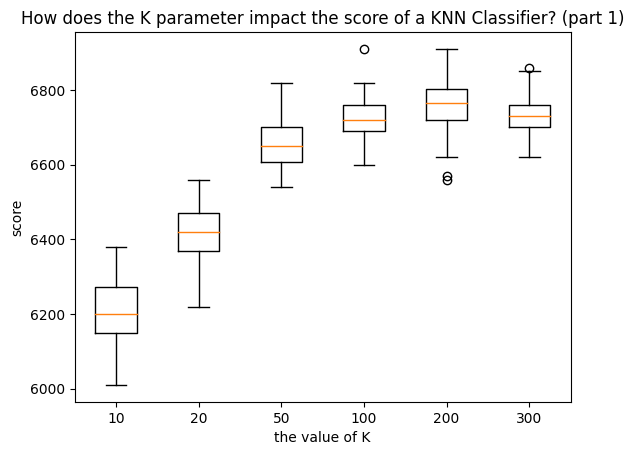

In [28]:
plt.boxplot((scores_knn_10, scores_knn_20, scores_knn_50, scores_knn_100, scores_knn_200, scores_knn_300),
            labels=[10, 20, 50, 100, 200, 300])
plt.title("How does the K parameter impact the score of a KNN Classifier? (part 1)")
plt.xlabel("the value of K")
plt.ylabel("score")
plt.show()

KNN between 100 and 300 seems to be best, so let's test them

In [34]:
ks = np.arange(100, 301, 10)
results = {}
for k in ks:
  scores = []
  for _ in range(100):
    seed = np.random.randint(low=3, high=2147483647)
    score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=k)
    scores.append(score)

  scores = np.array(scores)
  results[k] = np.mean(scores)

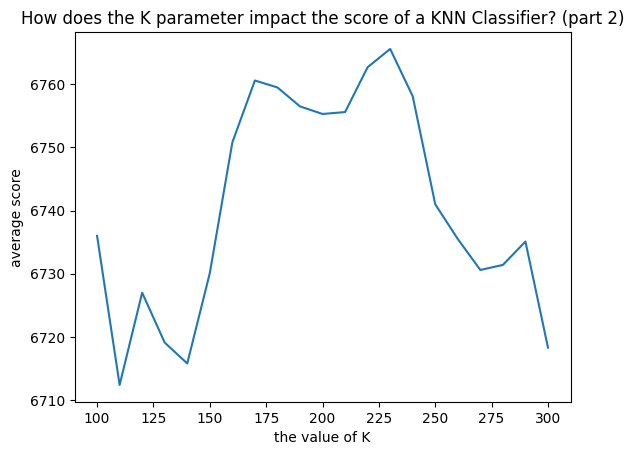

In [35]:
b = [results[key] for key in results]
a = [key for key in results]
plt.plot(a,b)
plt.title("How does the K parameter impact the score of a KNN Classifier? (part 2)")
plt.ylabel("average score")
plt.xlabel("the value of K")
plt.show()

In [17]:
scores_knn_no_outlabeling = []
for i in range(200):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=200)
  # print(i, score)
  scores_knn_no_outlabeling.append(score)

In [18]:
scores_knn_with_outlabeling = []
for i in range(200):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3,y=y, selection=[True,True,True], seed=seed, model_type='knn', model_size=200, outlabeling=True)
  # print(i, score)
  scores_knn_with_outlabeling.append(score)

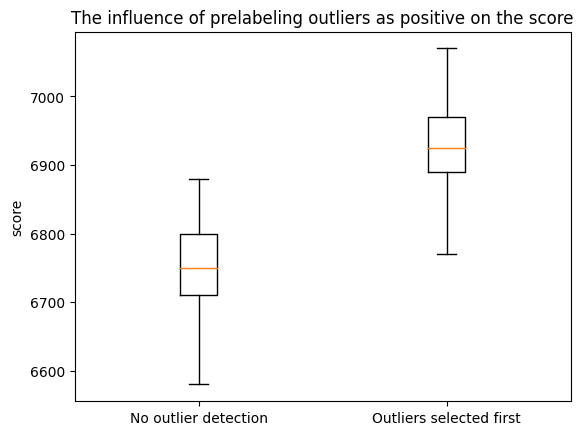

In [27]:
plt.boxplot((scores_knn_no_outlabeling, scores_knn_with_outlabeling),
            labels = ["No outlier detection", "Outliers selected first"])
plt.title("The influence of prelabeling outliers as positive on the score")
plt.ylabel("score")
plt.show()

In [12]:
X3aug = []
X3aug.append(X3[:,0])
X3aug.append(X3[:,1])
X3aug.append(X3[:,2])
X3aug.append(X3[:,0] * X3[:,1])
X3aug.append(X3[:,1] * X3[:,2])
X3aug.append(X3[:,2] * X3[:,0])
X3aug = np.column_stack(X3aug)

In [13]:
scores_aug_rf_no_outlabeling = []
for i in range(50):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3aug, y=y, selection=[True,True,True,True,True,True], seed=seed, model_type='rf', model_size=12)
  print(i, score)
  scores_aug_rf_no_outlabeling.append(score)

0 5790.0
1 5670.0
2 5650.0
3 5720.0
4 5640.0
5 5640.0
6 5770.0
7 5810.0
8 5790.0
9 5750.0
10 5800.0
11 5770.0
12 5800.0
13 5720.0
14 5640.0
15 5760.0
16 5730.0
17 5700.0
18 5570.0
19 5680.0
20 5590.0
21 5730.0
22 5750.0
23 5740.0
24 5620.0
25 5770.0
26 5700.0
27 5610.0
28 5710.0
29 5570.0
30 5770.0
31 5840.0
32 5670.0
33 5560.0
34 5700.0
35 5640.0
36 5710.0
37 5680.0
38 5690.0
39 5570.0
40 5740.0
41 5690.0
42 5850.0
43 5600.0
44 5570.0
45 5770.0
46 5700.0
47 5910.0
48 5750.0
49 5820.0


In [14]:
scores_aug_rf_with_outlabeling = []
for i in range(50):
  seed = np.random.randint(low=3, high=2147483647)
  score = selection_score_CV(X=X3aug, y=y, selection=[True,True,True,True,True,True], seed=seed, model_type='rf', model_size=12, outlabeling=True)
  print(i, score)
  scores_aug_rf_with_outlabeling.append(score)

0 6010.0
1 6060.0
2 6120.0
3 6030.0
4 6070.0
5 6050.0
6 6120.0
7 6070.0
8 5990.0
9 6070.0
10 6100.0
11 5950.0
12 6060.0
13 6180.0
14 5940.0
15 6160.0
16 6070.0
17 6060.0
18 6080.0
19 6120.0
20 6020.0
21 6090.0
22 6030.0
23 6200.0
24 6080.0
25 6180.0
26 6030.0
27 6010.0
28 5950.0
29 6060.0
30 6060.0
31 6100.0
32 6060.0
33 6090.0
34 6020.0
35 6100.0
36 6040.0
37 6150.0
38 6050.0
39 6050.0
40 6100.0
41 6110.0
42 6080.0
43 6070.0
44 6150.0
45 6110.0
46 6000.0
47 5910.0
48 6140.0
49 5980.0


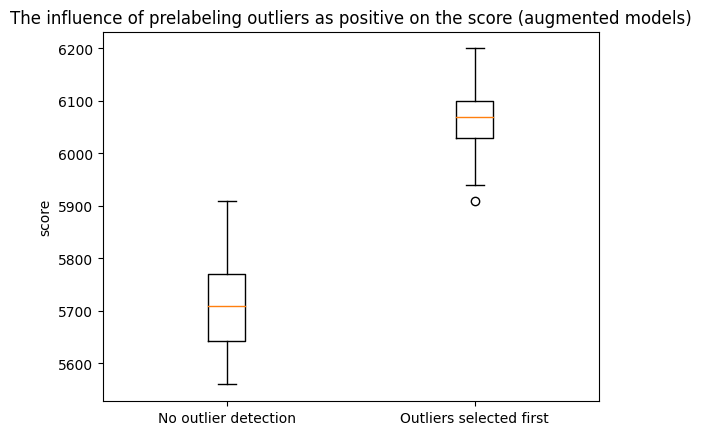

In [15]:
plt.boxplot((scores_aug_rf_no_outlabeling, scores_aug_rf_with_outlabeling),
            labels = ["No outlier detection", "Outliers selected first"])
plt.title("The influence of prelabeling outliers as positive on the score (augmented models)")
plt.ylabel("score")
plt.show()

predicting

In [38]:
X, y = load_data("x_train.txt", "y_train.txt")

In [36]:
X_test, y = load_data("x_test.txt", "y_train.txt")

In [39]:
X3_test = X_test[:,[102,103,105]]
X3 = X[:,[102,103,105]]

In [40]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X3,y)

KNeighborsClassifier(n_neighbors=200)

In [41]:
if knn.classes_[0] == 0:
    zero_index = 0
else:
    zero_index = 1
preds = knn.predict_proba(X3_test)[:,zero_index]

In [42]:
isofor = IsolationForest()
isofor.fit(X3)
out_labels = isofor.predict(X3_test)
for i, val in enumerate(out_labels):
  if val == -1:
    preds[i] = 0

In [45]:
ranking = np.argsort(preds)
selected = ranking[0:1000] + np.ones(1000)

In [47]:
print(selected[0:100])
print(selected[100:200])
print(selected[200:300])
print(selected[300:400])
print(selected[400:500])
print(selected[500:600])
print(selected[600:700])
print(selected[700:800])
print(selected[800:900])
print(selected[900:1000])


[2500. 2871. 1373. 4252. 2874. 1365. 1362. 4254. 1360. 1359. 3410. 2877.
 4256. 3408. 1351. 1350. 1349. 1348. 2880. 2883. 4243. 1336. 2869. 4241.
 4209. 2862. 4210. 4211. 4217. 4218. 4219. 3418. 4221. 4226. 2866. 4230.
 4233. 4235. 2867. 1394. 1390. 1385. 1383. 1381. 4266. 1334. 4269. 4314.
 1262. 1261. 4315. 1256. 4323. 4325. 1251. 1249. 1248. 1245. 1244. 1236.
 1235. 4334. 4336. 4337. 4342. 1212. 2905. 4311. 4310. 1273. 2884. 1330.
 1324. 4279. 1320. 1318. 4280. 1312. 1311. 4208. 1310. 4285. 4286. 4288.
 4292. 3386. 1287. 1286. 2899. 2902. 1309. 1209. 2858. 4202. 1591. 4113.
 1583. 1582. 1578. 3442.]
[1569. 1564. 4115. 1557. 4122. 1555. 4124. 4125. 1551. 1548. 1545. 1544.
 2827. 1597. 4131. 1600. 1602. 1648. 1642. 1641. 4080. 4081. 1636. 1628.
 4090. 1623. 1620. 4091. 1617. 2814. 1615. 4094. 1612. 4096. 1608. 1605.
 1601. 2828. 1536. 4132. 1471. 2849. 4177. 4178. 3424. 4179. 1457. 1448.
 4189. 1442. 4194. 1439. 4197. 1436. 1435. 1433. 4198. 4199. 4201. 4173.
 4172. 4162. 3427. 4135. 

In [49]:
selected = selected.astype(int)
with open("obs.txt", 'w') as writer:
  for i in range(1000):
    writer.write(str(selected[i]))
    writer.write("\n")